In [14]:
import wandb
import os
import re

import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style='darkgrid')
%matplotlib inline


def calc_c95(table, value, group_name='name'):

    print(value)
    stats = table.groupby([group_name])[value].agg(['mean', 'count', 'std'])

    ci95_hi = []
    ci95_lo = []

    for i in stats.index:
        m, c, s = stats.loc[i]
        ci95_hi.append(+ 1.96*s/np.sqrt(c))
        ci95_lo.append(- 1.96*s/np.sqrt(c))

    stats['ci95_hi'] = ci95_hi
    stats['ci95_lo'] = ci95_lo

    print(stats)
    print('\n')

# Width

In [3]:
name = 'cifar10_plain_none_128_0'

# check id
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name == name:
        run_id = run.id
        print(run.name, run.id)
        break

cifar10_plain_none_128_0 2me7fycz


In [15]:
ENV = 'mnist'

run_dict = {}

api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
for run in runs:
    if run.name.startswith(ENV + '_plain_none'):
        run_dict[ENV] = run
        print(run.name, run.id)
    elif run.name.startswith('fgsm-'+ ENV + '_plain_none'):
        run_dict['fgsm-' + ENV] = run
        print(run.name, run.id)
    elif run.name.startswith('pgd-' + ENV + '_plain_none'):
        run_dict['pgd-' + ENV] = run
        print(run.name, run.id)
        
baseline_dict = {}

for env, run in run_dict.items():
    # train
    if env == ENV:
        baseline = pd.DataFrame()
        history = run.history(samples=1000)
        baseline['train_acc'] = history['train_acc'].dropna()
        baseline['epoch'] = history['epoch'].dropna()
    # attack
    else:
        baseline = pd.DataFrame()
        history = run.history(samples=1000)
        baseline['attack_acc'] = history['attack_acc'].dropna()
        baseline['eps'] = history['eps'].dropna()
    baseline_dict[env] = baseline
    print(baseline)

pgd-mnist_plain_none_50_0 1c2u2ibz
fgsm-mnist_plain_none_50_0 1rfeboyz
mnist_plain_none_50_0 11ndw16g
   attack_acc   eps
0      0.9925  0.00
1      0.9107  0.05
2      0.4734  0.10
3      0.0716  0.15
4      0.0028  0.20
5      0.0001  0.25
6      0.0000  0.30
   attack_acc   eps
0      0.9925  0.00
1      0.9442  0.05
2      0.7722  0.10
3      0.5062  0.15
4      0.2953  0.20
5      0.1552  0.25
6      0.0795  0.30
     train_acc  epoch
59    0.956450    1.0
120   0.984367    2.0
181   0.989433    3.0
242   0.992283    4.0
303   0.993967    5.0
364   0.995167    6.0
425   0.996450    7.0
486   0.997067    8.0
547   0.997850    9.0
608   0.998200   10.0


In [4]:
# find runs
api = wandb.Api()
runs = api.runs("liuyuezhang/cerebellum")
print(len(runs))

233


In [17]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp[''] = '${}$'.format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = env + '_' + method + '_' + ltd + '_' + str(n)
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                           mean  count       std   ci95_hi   ci95_lo
name                                                                
mnist_fc_none_1000    92.155001      2  0.082494  0.114331 -0.114331
mnist_fc_none_10000   98.057500      2  0.045961  0.063699 -0.063699
mnist_fc_none_100000  99.244168      2  0.034177  0.047367 -0.047367
mnist_fc_none_2000    94.666666      2  0.061282  0.084932 -0.084932
mnist_fc_none_20000   98.665833      2  0.024749  0.034300 -0.034300
mnist_fc_none_200000  99.309167      2  0.027105  0.037565 -0.037565
mnist_fc_none_5000    96.940833      2  0.055389  0.076766 -0.076766
mnist_fc_none_50000   99.120000      2  0.011788  0.016338 -0.016338


best_test_acc
                           mean  count       std   ci95_hi   ci95_lo
name                                                                
mnist_fc_none_1000    93.140000      2  0.212134  0.294002 -0.294002
mnist_fc_none_10000   97.239998      2  0.183849  0.254801 -0.254801
mni

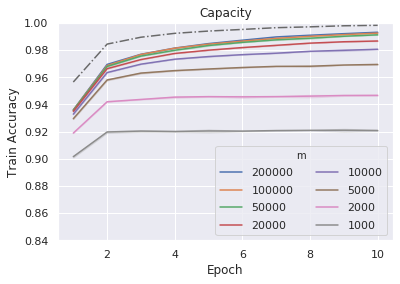

In [18]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$100000$', '$50000$', '$20000$', '$10000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title='Capacity', xlabel='Epoch', ylabel='Train Accuracy')
plt.ylim(0.84, 1.0)
plt.legend(loc='lower right', ncol=2, title='m')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300)

In [84]:
ATTACK = 'fgsm'
ENV = ATTACK + '-mnist'
METHOD = 'fc'
LTD = ['none']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp[''] = "${}$".format(n)
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        name = env + '_' + method + '_' + ltd + '_' + str(n)
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                             mean  count       std  ci95_hi  ci95_lo
name                                                                
fgsm-mnist_fc_none_1000     9.560      2  0.169706   0.2352  -0.2352
fgsm-mnist_fc_none_10000   16.060      2  3.097128   4.2924  -4.2924
fgsm-mnist_fc_none_100000  22.065      2  5.734636   7.9478  -7.9478
fgsm-mnist_fc_none_2000    13.290      2  0.721249   0.9996  -0.9996
fgsm-mnist_fc_none_20000   19.990      2  3.563818   4.9392  -4.9392
fgsm-mnist_fc_none_200000  24.485      2  2.807214   3.8906  -3.8906
fgsm-mnist_fc_none_5000    16.295      2  0.388909   0.5390  -0.5390
fgsm-mnist_fc_none_50000   16.280      2  2.701148   3.7436  -3.7436




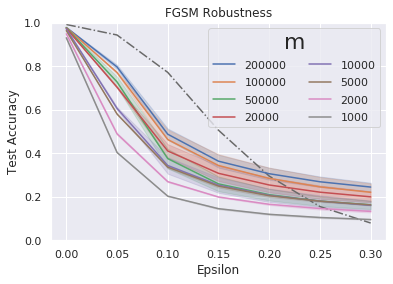

In [105]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgray')
ax = sns.lineplot(x='eps', y='attack_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$100000$', '$50000$', '$20000$', '$10000$', '$5000$', '$2000$', '$1000$'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(0, 1)
plt.legend(loc='upper right', ncol=2, title='m')
# plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/wide_'+ENV+'.png', dpi=300)

# LTD

In [38]:
ENV = 'mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))

    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp['m'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)
        name = env + '_' + method + '_' + ltd + '_' + str(n)
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                           mean  count       std   ci95_hi   ci95_lo
name                                                                
mnist_fc_ma_1000      93.185833      2  0.020032  0.027763 -0.027763
mnist_fc_ma_10000     98.406667      2  0.035353  0.048996 -0.048996
mnist_fc_ma_100000    99.216667      2  0.002356  0.003265 -0.003265
mnist_fc_ma_2000      95.495835      2  0.041249  0.057168 -0.057168
mnist_fc_ma_20000     98.863333      2  0.018857  0.026134 -0.026134
mnist_fc_ma_200000    99.263334      2  0.014144  0.019603 -0.019603
mnist_fc_ma_5000      97.526667      2  0.002356  0.003265 -0.003265
mnist_fc_ma_50000     99.145001      2  0.004712  0.006531 -0.006531
mnist_fc_none_1000    92.155001      2  0.082494  0.114331 -0.114331
mnist_fc_none_10000   98.057500      2  0.045961  0.063699 -0.063699
mnist_fc_none_100000  99.244168      2  0.034177  0.047367 -0.047367
mnist_fc_none_2000    94.666666      2  0.061282  0.084932 -0.084932
mnist_fc_none_20000

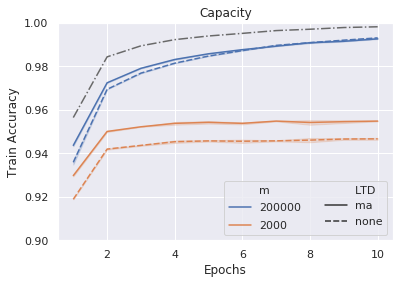

In [39]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='m', style='LTD', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$2000$'],
                  style_order=['ma', 'none'],
                  data=df)
ax.set(title='Capacity', xlabel='Epochs', ylabel='Train Accuracy')
plt.ylim(0.9, 1.0)
plt.legend(loc='lower right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300)

In [42]:
ATTACK = 'pgd'
ENV = ATTACK + '-mnist'
METHOD = 'fc'
LTD = ['none', 'ma']
N = [1000, 2000, 5000, 10000, 20000, 50000, 100000, 200000]

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)_(.*)_(.*)_(.*)', run.name)
    env = m.group(1)
    method = m.group(2)
    ltd = m.group(3)
    n = int(m.group(4))
    seed = int(m.group(5))
    
    if env == ENV and method == METHOD and ltd in LTD and n in N:
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp['m'] = '${}$'.format(n)
        temp['LTD'] = ltd
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = history['max_attack_acc'].dropna().item() * 100
        name = env + '_' + method + '_' + ltd + '_' + str(n)
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                            mean  count       std  ci95_hi  ci95_lo
name                                                               
pgd-mnist_fc_ma_1000      13.770      2  4.582052   6.3504  -6.3504
pgd-mnist_fc_ma_10000     20.490      2  0.339411   0.4704  -0.4704
pgd-mnist_fc_ma_100000    11.395      2  0.049497   0.0686  -0.0686
pgd-mnist_fc_ma_2000      22.515      2  2.665793   3.6946  -3.6946
pgd-mnist_fc_ma_20000     11.365      2  0.021213   0.0294  -0.0294
pgd-mnist_fc_ma_200000    11.390      2  0.056569   0.0784  -0.0784
pgd-mnist_fc_ma_5000      26.170      2  2.672864   3.7044  -3.7044
pgd-mnist_fc_ma_50000     14.485      2  4.433560   6.1446  -6.1446
pgd-mnist_fc_none_1000     1.440      2  0.240416   0.3332  -0.3332
pgd-mnist_fc_none_10000    1.445      2  0.205061   0.2842  -0.2842
pgd-mnist_fc_none_100000   0.960      2  0.325269   0.4508  -0.4508
pgd-mnist_fc_none_2000     1.905      2  0.148492   0.2058  -0.2058
pgd-mnist_fc_none_20000    1.340 

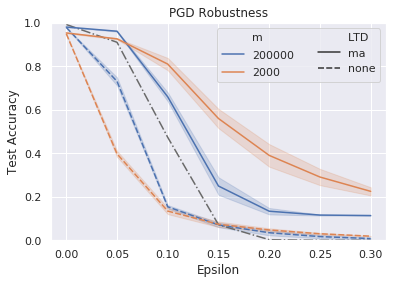

In [43]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='eps', y='attack_acc', hue='m', style='LTD', ci=95, n_boot=1000,
                  hue_order=['$200000$', '$2000$'],
                  style_order=['ma', 'none'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(0, 1.0)
plt.legend(loc='upper right', ncol=2)
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd_'+ENV+'.png', dpi=300)

# Sparseness

In [44]:
ENV = 'mnist'
K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]
METHOD = ['rc']
LTD = ['ma']

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        ltd = m.group(4)
        n = int(m.group(5))
        seed = int(m.group(6))

        if env == ENV and method in METHOD and k in K and ltd in LTD:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['best_train_acc'] = history['best_train_acc'].dropna()
            temp['best_test_acc'] = history['best_test_acc'].dropna()
            temp['Granule'] = method
            temp['k'] = k
            temp['seed'] = seed
            df = df.append(temp)

            best_train_acc = history['best_train_acc'].dropna().item() * 100
            best_test_acc = history['best_test_acc'].dropna().item() * 100
            name = env + '_' + method + '-' + str(k) + '_' + ltd + '_' + str(n)
            table = table.append(pd.DataFrame(
                {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                         mean  count       std   ci95_hi   ci95_lo
name                                                              
mnist_rc_ma_11429   98.346666      2  0.021213  0.029399 -0.029399
mnist_rc_ma_120000  97.553334      2  0.002356  0.003265 -0.003265
mnist_rc_ma_160000  96.775836      2  0.012964  0.017968 -0.017968
mnist_rc_ma_200000  94.769165      2  0.053033  0.073501 -0.073501
mnist_rc_ma_21818   98.509169      2  0.050677  0.070235 -0.070235
mnist_rc_ma_218182  91.151667      2  0.042425  0.058798 -0.058798
mnist_rc_ma_228571  85.489166      2  0.001180  0.001636 -0.001636
mnist_rc_ma_40000   98.364165      2  0.053033  0.073501 -0.073501
mnist_rc_ma_5970    97.826666      2  0.042425  0.058798 -0.058798
mnist_rc_ma_68571   98.105833      2  0.022393  0.031035 -0.031035


best_test_acc
                         mean  count       std   ci95_hi   ci95_lo
name                                                              
mnist_rc_ma_11429   97.485000  

[Text(0, 0.5, 'Train Accuracy'),
 None,
 Text(0.5, 0, 'k'),
 Text(0.5, 1.0, 'Capacity')]

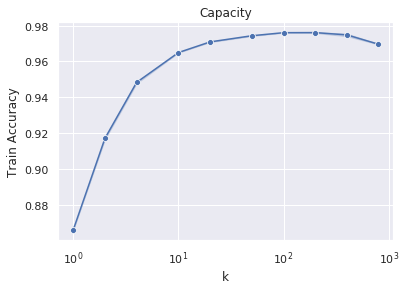

In [45]:
ax = sns.lineplot(x='k', y='best_test_acc', ci=95, n_boot=1000, marker='o',
                  data=df)
ax.set(title='Capacity', xlabel='k', xscale='log', ylabel='Train Accuracy')
# plt.ylim(0.3, 0.6)
# plt.legend(loc='lower right')
# plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/sparse_'+ENV+'.png', dpi=300)

In [51]:
ATTACK = 'pgd'
ENV = ATTACK + '-mnist'
K = [1, 2, 4, 10, 20, 50, 100, 200, 400, 784]

METHOD = ['rc']
LTD = ['ma']

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*)-(.*)_(.*)_(.*)_(.*)', run.name)
    if m is not None:
        env = m.group(1)
        method = m.group(2)
        k = int(m.group(3))
        ltd = m.group(4)
        n = int(m.group(5))
        seed = int(m.group(6))

        if env == ENV and method in METHOD and k in K and ltd in LTD:
            temp = pd.DataFrame()
            history = run.history(samples=1000)

            temp['attack_acc'] = history['attack_acc'].dropna()
#             temp[''] = history['eps'].dropna().apply(
#                 lambda x: '${}$'.format(int(x * 255)))
            temp[''] = history['eps'].dropna().apply(
                lambda x: '${}$'.format(x))            
            temp['k'] = k
            temp['Granule'] = method
            temp['seed'] = seed
            df = df.append(temp)

            max_attack_acc = history['max_attack_acc'].dropna().item() * 100
            name = env + '_' + method + '-' + str(k) + '_' + ltd + '_' + str(n)
            table = table.append(pd.DataFrame(
                {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                             mean  count       std  ci95_hi  ci95_lo
name                                                                
pgd-mnist_rc-100_ma_40000  24.640      2  1.994041   2.7636  -2.7636
pgd-mnist_rc-10_ma_160000  34.320      2  6.646804   9.2120  -9.2120
pgd-mnist_rc-1_ma_228571   29.215      2  0.586899   0.8134  -0.8134
pgd-mnist_rc-200_ma_21818  18.005      2  2.623366   3.6358  -3.6358
pgd-mnist_rc-20_ma_120000  27.730      2  0.438406   0.6076  -0.6076
pgd-mnist_rc-2_ma_218182   37.130      2  1.937473   2.6852  -2.6852
pgd-mnist_rc-400_ma_11429  17.900      2  4.610336   6.3896  -6.3896
pgd-mnist_rc-4_ma_200000   76.500      2  0.975807   1.3524  -1.3524
pgd-mnist_rc-50_ma_68571   26.400      2  0.509117   0.7056  -0.7056
pgd-mnist_rc-784_ma_5970   27.915      2  2.255671   3.1262  -3.1262




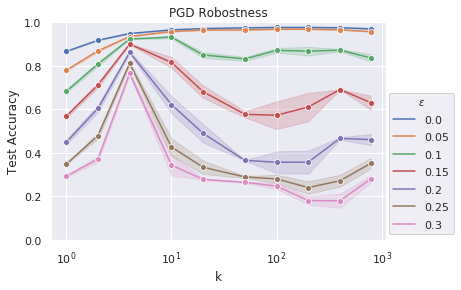

In [52]:
ax = sns.lineplot(x='k', y='attack_acc', hue='', ci=95, n_boot=1000, marker='o',
                  data=df)
ax.set(title=ATTACK.upper() + ' Robostness', xlabel='k', xscale='log', ylabel='Test Accuracy')
plt.ylim(0.0, 1.0)
lgd = plt.legend(loc='lower right', title='$\epsilon$', bbox_to_anchor=(1.22, 0))
# plt.ylim(0.0, 0.6)
# lgd = plt.legend(loc='lower right', title='$\epsilon\,(1/255)$', bbox_to_anchor=(1.22, 0))
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/ltd+sparse_'+ENV+'.png', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

# Cerebellum

In [54]:
ENV = 'mnist'
MODEL = {'plain_none_50': 'CNN', 
         'rc-4_ma_200000': 'Cerebellum',
         'rc-4_none_200000': 'Base + RC',
         'fc_ma_5970': 'Base + LTD',
         'fc_none_5970': 'Base'}


df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*_.*_.*)_(.*)', run.name)
    env = m.group(1)
    model = m.group(2)
    seed = int(m.group(3))
    
    if env == ENV and model in MODEL.keys():
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['train_acc'] = history['train_acc'].dropna()
        temp['epoch'] = history['epoch'].dropna()
        temp[''] = MODEL[model]
        temp['seed'] = seed
        df = df.append(temp)
        
        best_train_acc = history['best_train_acc'].dropna().item() * 100
        best_test_acc = history['best_test_acc'].dropna().item() * 100
        name = env + '_' + model
        table = table.append(pd.DataFrame(
            {'best_train_acc': best_train_acc, 'best_test_acc': best_test_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'best_train_acc')
calc_c95(table, 'best_test_acc')

best_train_acc
                             mean  count       std   ci95_hi   ci95_lo
name                                                                  
mnist_fc_ma_5970        97.823334      2  0.014144  0.019603 -0.019603
mnist_fc_none_5970      97.281668      2  0.047141  0.065334 -0.065334
mnist_plain_none_50     99.820000      1       NaN       NaN       NaN
mnist_rc-4_ma_200000    94.769165      2  0.053033  0.073501 -0.073501
mnist_rc-4_none_200000  94.711664      2  0.021213  0.029399 -0.029399


best_test_acc
                             mean  count       std   ci95_hi   ci95_lo
name                                                                  
mnist_fc_ma_5970        96.930000      2  0.155560  0.215595 -0.215595
mnist_fc_none_5970      96.599999      2  0.070710  0.097999 -0.097999
mnist_plain_none_50     99.250001      1       NaN       NaN       NaN
mnist_rc-4_ma_200000    94.830000      2  0.084850  0.117596 -0.117596
mnist_rc-4_none_200000  94.965002      2  0.07

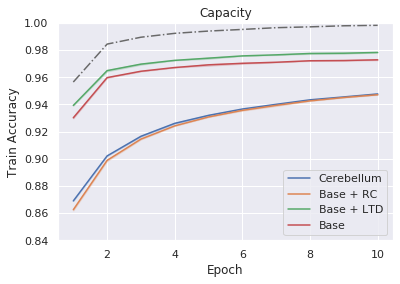

In [56]:
plt.plot(baseline_dict[ENV]['epoch'], baseline_dict[ENV]['train_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='epoch', y='train_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['Cerebellum', 'Base + RC', 'Base + LTD', 'Base'],
                  data=df)
ax.set(title='Capacity', xlabel='Epoch', ylabel='Train Accuracy')
plt.ylim(0.84, 1.0)
plt.legend(loc='lower right')
plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/cereb_'+ENV+'.png', dpi=300)

In [19]:
EPS = 0.1
ATTACK = 'pgd'
ENV = ATTACK + '-mnist'
MODEL = {'plain_none_50': 'CNN', 
         'rc-4_ma_200000': 'Cerebellum',
         'rc-4_none_200000': 'Base + RC',
         'fc_ma_5970': 'Base + LTD',
         'fc_none_5970': 'Base'}

df = pd.DataFrame()
table = pd.DataFrame()
for run in runs:    
    m = re.match('(.*)_(.*_.*_.*)_(.*)', run.name)
    env = m.group(1)
    model = m.group(2)
    seed = int(m.group(3))
    
    if env == ENV and model in MODEL.keys():
        temp = pd.DataFrame()
        history = run.history(samples=1000)
        temp['attack_acc'] = history['attack_acc'].dropna()
        temp['eps'] = history['eps'].dropna()
        temp[''] = MODEL[model]
        temp['seed'] = seed
        df = df.append(temp)
        
        max_attack_acc = temp[temp['eps'] == EPS]['attack_acc'].item() * 100
        name = env + '_' + model
        table = table.append(pd.DataFrame(
            {'max_attack_acc': max_attack_acc, 'name': name}, index=[run.name]))
    
calc_c95(table, 'max_attack_acc')

max_attack_acc
                              mean  count       std  ci95_hi  ci95_lo
name                                                                 
pgd-mnist_fc_ma_5970        86.170      2  2.234457   3.0968  -3.0968
pgd-mnist_fc_none_5970      14.905      2  0.982878   1.3622  -1.3622
pgd-mnist_plain_none_50     47.340      1       NaN      NaN      NaN
pgd-mnist_rc-4_ma_200000    92.300      2  0.127279   0.1764  -0.1764
pgd-mnist_rc-4_none_200000  56.235      2  0.530330   0.7350  -0.7350




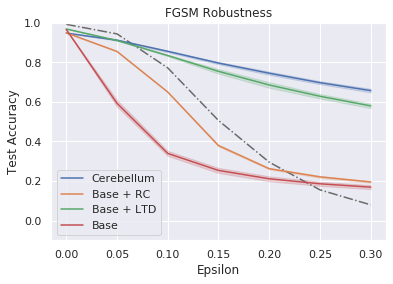

In [18]:
plt.plot(baseline_dict[ENV]['eps'], baseline_dict[ENV]['attack_acc'], '-.', color='dimgrey')
ax = sns.lineplot(x='eps', y='attack_acc', hue='', ci=95, n_boot=1000,
                  hue_order=['Cerebellum', 'Base + RC', 'Base + LTD', 'Base'],
                  data=df)
ax.set(title=ATTACK.upper() + ' Robustness', xlabel='Epsilon', ylabel='Test Accuracy')
plt.ylim(-0.1, 1.0)
plt.legend(loc='lower left')
# plt.savefig('/home/liuyuezhangadam/Desktop/cerebellum/fig/cereb_'+ENV+'.png', dpi=300)